<a href="https://colab.research.google.com/github/NBK-code/Time_Series_Data/blob/main/Time_Series_Stock_Pred_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

In [2]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400
...,...,...,...,...,...,...,...
9209,2022-09-26,237.050003,241.449997,236.899994,237.449997,237.449997,27694200
9210,2022-09-27,239.979996,241.800003,234.500000,236.410004,236.410004,27018700
9211,2022-09-28,236.809998,242.330002,234.729996,241.070007,241.070007,29029700
9212,2022-09-29,238.889999,239.949997,234.410004,237.500000,237.500000,27484200


In [3]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9209,2022-09-26,237.449997
9210,2022-09-27,236.410004
9211,2022-09-28,241.070007
9212,2022-09-29,237.500000


In [4]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9209    2022-09-26
9210    2022-09-27
9211    2022-09-28
9212    2022-09-29
9213    2022-09-30
Name: Date, Length: 9214, dtype: object

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [6]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9209,2022-09-26,237.449997
9210,2022-09-27,236.410004
9211,2022-09-28,241.070007
9212,2022-09-29,237.500000


In [7]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9209   2022-09-26
9210   2022-09-27
9211   2022-09-28
9212   2022-09-29
9213   2022-09-30
Name: Date, Length: 9214, dtype: datetime64[ns]

In [8]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-09-26,237.449997
2022-09-27,236.410004
2022-09-28,241.070007


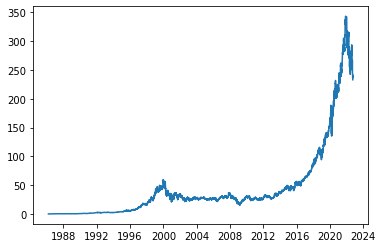

In [9]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [10]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [12]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

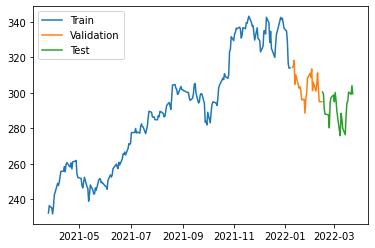

In [13]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 95ms/step - loss: 84950.2422 - mean_absolute_error: 289.7230 - val_loss: 92588.3672 - val_mean_absolute_error: 304.1963
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 84625.1250 - mean_absolute_error: 289.1624 - val_loss: 92319.5391 - val_mean_absolute_error: 303.7542
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 84427.8516 - mean_absolute_error: 288.8210 - val_loss: 92170.7969 - val_mean_absolute_error: 303.5092
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 84276.5938 - mean_absolute_error: 288.5599 - val_loss: 91992.6172 - val_mean_absolute_error: 303.2155
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 84097.7578 - mean_absolute_error: 288.2486 - val_loss: 91785.1797 - val_mean_absolute_error: 302.8733
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 83880.0234 - mean_absolute_error: 287.8710 - val_loss: 91511.

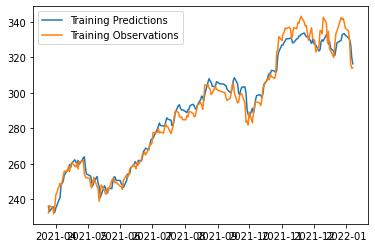

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

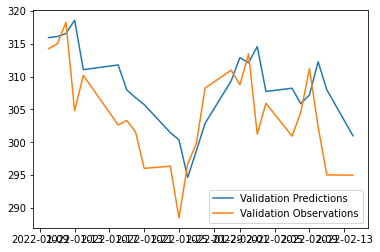

In [16]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

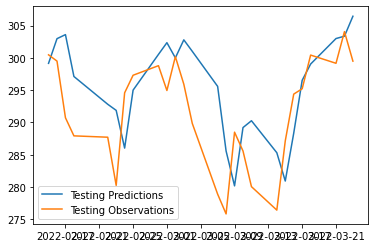

In [17]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

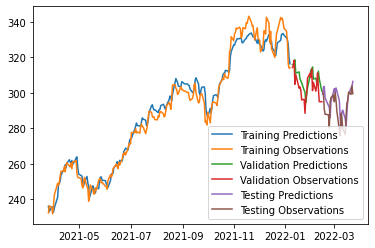

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [19]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

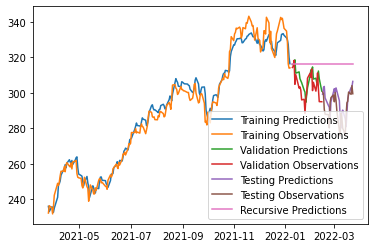

In [20]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])